In [3]:
%load_ext autoreload
%autoreload 2

from neural_circuits.LRRNN import get_W_eigs_np
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import torch
torch.manual_seed(0)

import tensorflow as tf
from epi.models import Model, Parameter
from epi.util import get_max_H_dist
from neural_circuits.LRRNN import get_W_eigs_tf, get_simulator, get_snpe_times, \
                                  has_converged, get_convergence_round, \
                                  tf_num_params, torch_num_params


"""RNN stable amplification."""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'RNN stable amplification.'

### Plot arch size

/Users/sbittner/anaconda/envs/sbi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/sbi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


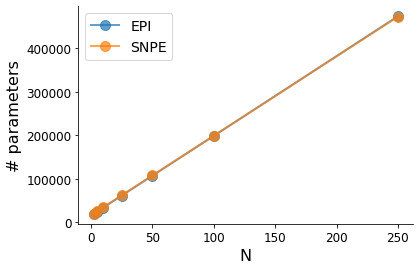

In [4]:
colors = sns.color_palette()
Ns = [2, 5, 10, 25, 50, 100, 250]
epi_num_params = []
snpe_num_params = []
for N in Ns:
    epi_num_params.append(tf_num_params(N))
    snpe_num_params.append(torch_num_params(N))
    
plt.figure()
plt.plot(Ns, epi_num_params, '-o', c=colors[0], label="EPI", alpha=0.7)
plt.plot(Ns, snpe_num_params, '-o', c=colors[1], label="SNPE", alpha=0.7)
plt.xlabel('N')
plt.ylabel('# parameters')
plt.legend()
plt.show()

## 1. Load SNPE results

Processing SNPE_RNN_stab_amp_N=50_sims=5000_batch=200_transforms=3_atoms=100_g=0.1000_K=1_rs=1.
# rounds = 8
adding best posterior.
Processing SNPE_RNN_stab_amp_N=50_sims=5000_batch=200_transforms=3_atoms=100_g=0.1000_K=1_rs=2.
# rounds = 6
Processing SNPE_RNN_stab_amp_N=50_sims=5000_batch=200_transforms=3_atoms=100_g=0.1000_K=1_rs=3.
# rounds = 10
adding best posterior.
Processing SNPE_RNN_stab_amp_N=50_sims=5000_batch=200_transforms=3_atoms=100_g=0.1000_K=1_rs=4.
# rounds = 52
adding best posterior.
Processing SNPE_RNN_stab_amp_N=50_sims=5000_batch=200_transforms=3_atoms=100_g=0.1000_K=1_rs=5.
# rounds = 41


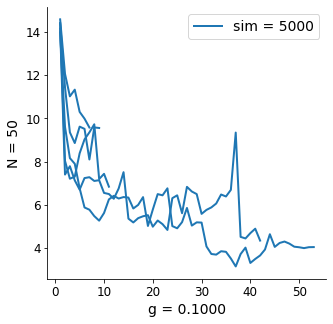

In [5]:
base_path = os.path.join("data", "snpe")
fontsize=14
calc_conv_time = False
plotstr = "distance"
x0 = np.array([0.5, 1.5])

num_transforms = 3
K = 1
num_sims = [5000]
num_batches = [200]
num_atoms = [100]

Ns = [50]
gs = [0.1]
num_Ns = len(Ns)
num_gs = len(gs)
random_seeds = [1,2,3,4,5]

colors = sns.color_palette()
figlen = 5
if plotstr == "log_prob":
    xlabel = 'time (min)'
    ylabel = 'validation log prob'
elif plotstr == "distance":
    xlabel = 'rounds'
    ylabel = 'distance'

snpe_posteriors = {}
snpe_conv_times = {}

fontsize=14
fig, axs = plt.subplots(num_Ns, num_gs, figsize=(num_gs*figlen,num_Ns*figlen))
for i, N in enumerate(Ns):
    for j, g in enumerate(gs):
        if (num_Ns == 1 and num_gs == 1):
            ax = axs
        elif (num_Ns == 1 or num_gs == 1):
            ax = axs[i+j]
        else:
            ax = axs[i][j]
        best_val_prob = None
        best_posterior = None
        for _i, rs in enumerate(random_seeds):
            for _j, _num_sims in enumerate(num_sims):
                for _k, num_batch in enumerate(num_batches):
                    for _ii, _num_atoms in enumerate(num_atoms):
                        save_dir = "SNPE_RNN_stab_amp_N=%d_sims=%d_batch=%d_transforms=%d_atoms=%d_g=%.4f_K=%d_rs=%d" \
                                % (N, _num_sims, num_batch, num_transforms, _num_atoms, g, K, rs)
                        print("Processing %s." % save_dir)
                        #print("Processing %s.\r" % save_dir, end="")
                        save_path = os.path.join(base_path, save_dir)
                        if os.path.isdir(save_path):
                            file = os.path.join(save_path, "optim.pkl")
                            try:
                                with open(file, "rb") as f:
                                    optim = pickle.load(f)
                            except:
                                print("Error: no optim file %s." % file)
                                continue
                        else:
                            print("Error: no save path %s." % save_path)
                            continue

                        summary = optim['summary']
                        round_val_log_probs = optim['round_val_log_probs']
                        print('# rounds = %d' % len(round_val_log_probs))
                        val_log_probs = summary['validation_log_probs']

                        epoch_times, round_times = get_snpe_times(optim) 
                        label = None
                        if _i == 0:
                            label = "sim = %d" % _num_sims
                        if plotstr == 'log_prob':
                            x = epoch_times[1:]/60.
                            y = summary['validation_log_probs']
                        elif plotstr == "distance":
                            y = optim["distances"]
                            x = np.arange(1, len(y)+1)
                        ax.plot(x, y, c=colors[_j], label=label)
                        best_val_prob_i = np.max(round_val_log_probs)
                        if best_val_prob is None or best_val_prob_i > best_val_prob:
                            print('adding best posterior.')
                            snpe_posteriors.update({(N,g,K):optim['zs'][np.argmax(round_val_log_probs)]})
                            best_val_prob = best_val_prob_i

                        if calc_conv_time:
                            conv_round = get_convergence_round(optim, g, K, x0, 0.5)
                            snpe_conv_times.update({(N,g,K,_num_sims,num_batch,_num_atoms,rs):round_times[conv_round]})
        if i==0:
            if num_Ns == 1:
                ax.set_xlabel('g = %.4f' % g, fontsize=fontsize)
            else:
                ax.set_title('g = %.4f' % g, fontsize=fontsize)
        if i==(num_Ns-1) and num_Ns > 1:
            ax.set_xlabel(xlabel, fontsize=fontsize)
        if j==0:
            ax.set_ylabel('N = %d' % N, fontsize=fontsize)
        if i==0 and j==0:
            ax.legend()
plt.show()